In [347]:
import csv
import sys
import os
import pickle
import random
import numpy as np
import time
import operator
import seaborn as sns
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from collections import Counter

import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.api as sm

import scipy.stats
from scipy.stats import entropy
from scipy.stats import spearmanr, pearsonr
from scipy.stats import zscore

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, KFold

import xgboost as xgb
import shap

In [348]:
sys.path.append('../python')
from permutation import permutation, compute_alignment_strength
from utils.utils_funcs import get_variance, get_distinctness, get_distinctness_from_nearest_5
from utils.utils_funcs import load_data_to_dict

In [349]:
# aggregate both visual embeddings and language embeddings
def aggregate_embeddings_visual_and_language(input_struct,n_sample_per_visual,n_sample_per_language):
	words=input_struct['words']
	embed_dict=dict()
	for word in words:
		n_sample_v = min(len(input_struct['embeds'][word]['visual']), n_sample_per_visual)
		visual_temp=np.mean(np.array(random.sample(input_struct['embeds'][word]['visual'],n_sample_v)),axis=0)
		n_sample_l = min(len(input_struct['embeds'][word]['language']), n_sample_per_language)
		language_temp=np.mean(np.array(random.sample(input_struct['embeds'][word]['language'],n_sample_l)),axis=0)
		#embed_dict[word]=dict(visual=np.expand_dims(visual_temp,axis=0),language=language_temp)
		embed_dict[word]=dict(visual=visual_temp,language=np.squeeze(language_temp))
	return dict(embeds=embed_dict,words=words)

In [350]:
def combine_nouns_and_verbs(struct1,struct2):
    words_full=list()
    embeds_full=dict()
    for w in struct1["embeds"]:
        ww=w+"_n"
        temp=dict()
        temp["visual"]=struct1["embeds"][w]["visual"]
        temp["language"]=struct1["embeds"][w]["language"]
        embeds_full[ww]=temp
        words_full.append(ww)
    for w in struct2["embeds"]:
        ww=w+"_v"
        temp=dict()
        temp["visual"]=struct2["embeds"][w]["visual"]
        temp["language"]=struct2["embeds"][w]["language"]
        embeds_full[ww]=temp
        words_full.append(ww)
    data_full=dict(
        embeds=embeds_full,
        words=words_full
    )
    return data_full

In [351]:
def get_concept_level_alignment_strength(struct,concepts,targets):
    visual_embeddings_list=list()
    langauge_embeddings_list=list()
    for concept in concepts:
        embeddings=struct["embeds"][concept]
        visual_embeddings_list.append(embeddings["visual"])
        langauge_embeddings_list.append(embeddings["language"])
    z_0=np.array(visual_embeddings_list)
    z_1=np.array(langauge_embeddings_list)
    sim_z_0=cosine_similarity(z_0)
    sim_z_1=cosine_similarity(z_1)
    rt=list()
    for target in targets:
        idx=concepts.index(target)
        aln=spearmanr(sim_z_0[idx],sim_z_1[idx])[0]
        if aln>0:
            rt.append(aln)
        else:
            rt.append(0)
    return rt

In [352]:
def combine_all_data(data,aoa_dict,v_var_dict,l_var_dict,v_dist_dict,l_dist_dict):
    aoas=list()
    v_vars=list()
    l_vars=list()
    v_dists=list()
    l_dists=list()
    
    intersect_concepts=list()
    for concept in aoa_dict:
        if concept in data['words']:
            aoas.append(aoa_dict[concept])
            v_vars.append(v_var_dict[concept])
            l_vars.append(l_var_dict[concept])
            v_dists.append(v_dist_dict[concept])
            l_dists.append(l_dist_dict[concept])
            intersect_concepts.append(concept)
    alignments=get_concept_level_alignment_strength(data,data['words'],intersect_concepts)
    return aoas,alignments,v_vars,l_vars,v_dists,l_dists

In [353]:
# vg_noun_data=pickle.load(open("../data/dumped_embeddings/vg_noun_swav_bert_window5_20.pkl","rb"))
# vg_verb_data=pickle.load(open("../data/dumped_embeddings/vg_verb_swav_bert_window5_20.pkl","rb"))

# aggregated_vg_noun_data=aggregate_embeddings_visual_and_language(vg_noun_data,20,20)
# aggregated_vg_verb_data=aggregate_embeddings_visual_and_language(vg_verb_data,20,20)

In [354]:
vg_noun_data=pickle.load(open("../data/dumped_embeddings/vg_noun_ll_swav_bert_20.pkl","rb"))
vg_verb_data=pickle.load(open("../data/dumped_embeddings/vg_verb_ll_swav_bert_20.pkl","rb"))

aggregated_vg_noun_data=aggregate_embeddings_visual_and_language(vg_noun_data,20,20)
aggregated_vg_verb_data=aggregate_embeddings_visual_and_language(vg_verb_data,20,20)

In [355]:
# vg_noun_data=pickle.load(open("../data/dumped_embeddings/vg_noun_concept_least20_swav_bert_20.pkl","rb"))
# vg_verb_data=pickle.load(open("../data/dumped_embeddings/vg_verb_concept_least20_swav_bert_20.pkl","rb"))

# aggregated_vg_noun_data=aggregate_embeddings_visual_and_language(vg_noun_data,20,20)
# aggregated_vg_verb_data=aggregate_embeddings_visual_and_language(vg_verb_data,20,20)

In [356]:
# vg_noun_data=pickle.load(open("../data/dumped_embeddings/vg_noun_concept_least20_swav_glove_20.pkl","rb"))
# vg_verb_data=pickle.load(open("../data/dumped_embeddings/vg_verb_concept_least20_swav_glove_20.pkl","rb"))

# aggregated_vg_noun_data=aggregate_embeddings_visual_and_language(vg_noun_data,20,1)
# aggregated_vg_verb_data=aggregate_embeddings_visual_and_language(vg_verb_data,20,1)

In [357]:
vg_all_data=combine_nouns_and_verbs(vg_noun_data,vg_verb_data)
aggregated_vg_all_data=aggregate_embeddings_visual_and_language(vg_all_data,20,20)

----

In [358]:
noun_aoa_dict=load_data_to_dict("../data/processed/aoa/kuperman_noun_aoa.txt",concepts=vg_noun_data["words"])
verb_aoa_dict=load_data_to_dict("../data/processed/aoa/kuperman_verb_aoa.txt",concepts=vg_verb_data["words"])

noun_aoa_sorted = sorted(noun_aoa_dict.items(), key=operator.itemgetter(1))
verb_aoa_sorted = sorted(verb_aoa_dict.items(), key=operator.itemgetter(1))

In [359]:
# noun_aoa_dict=load_data_to_dict("../data/processed/aoa/wordbank_noun_aoa.txt",concepts=vg_noun_data["words"])
# verb_aoa_dict=load_data_to_dict("../data/processed/aoa/wordbank_verb_aoa.txt",concepts=vg_verb_data["words"])

# noun_aoa_sorted = sorted(noun_aoa_dict.items(), key=operator.itemgetter(1))
# verb_aoa_sorted = sorted(verb_aoa_dict.items(), key=operator.itemgetter(1))

In [360]:
# noun_aoa_dict=load_data_to_dict("../data/processed/aoa/glasgow_noun_aoa.txt",concepts=vg_noun_data["words"])
# verb_aoa_dict=load_data_to_dict("../data/processed/aoa/glasgow_verb_aoa.txt",concepts=vg_verb_data["words"])

# noun_aoa_sorted = sorted(noun_aoa_dict.items(), key=operator.itemgetter(1))
# verb_aoa_sorted = sorted(verb_aoa_dict.items(), key=operator.itemgetter(1))

In [361]:
all_aoa_dict=dict()
for w in noun_aoa_dict:
    ww=w+"_n"
    all_aoa_dict[ww]=noun_aoa_dict[w]
for w in verb_aoa_dict:
    ww=w+"_v"
    all_aoa_dict[ww]=verb_aoa_dict[w]

----

## nouns+verbs

In [362]:
all_visual_variability,all_language_variability=get_variance(vg_all_data)

In [363]:
all_visual_discriminability,all_language_discriminability=get_distinctness_from_nearest_5(vg_all_data)

----

In [364]:
aoas,alignments,v_vars,l_vars,v_dists,l_dists=combine_all_data(aggregated_vg_all_data,all_aoa_dict,
                                                              all_visual_variability,all_language_variability,
                                                              all_visual_discriminability,all_language_discriminability)

In [365]:
df=pd.DataFrame(data=np.transpose(np.array([aoas,alignments,v_vars,l_vars,v_dists,l_dists])),columns=['aoa','alignment','v_variability','l_variability','v_discriminability','l_discriminability'])
# df1['type']='noun'

In [366]:
# df

In [367]:
# df['type']=df['type'].astype("category")

In [368]:
# df.dtypes

### Xgboost

In [369]:
x=df.iloc[:,1:]

In [370]:
y=df.iloc[:,:1]

In [371]:
# # Shuffling the data
# X_shuffle, y_shuffle = shuffle(x, y)

In [372]:
# xgb_rg = xgb.XGBRegressor(max_depth=3, n_estimators=100,
#                             objective ='reg:linear', booster='gbtree',
#                             n_jobs=2)

# # Cross-validation with 10 folds
# mse = cross_val_score(xgb_rg, X_shuffle, y_shuffle,
#                          scoring='neg_mean_squared_error',
#                          cv=10, n_jobs=-1)

# print("MSE Values: ", -1 * np.round(mse, 2))
# print("Average MSE: ", -1 * np.mean(mse))

In [373]:
test_size=0.2
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size)

In [374]:
# xgb_full= xgb.DMatrix(x, label=y)
# xgb_train = xgb.DMatrix(X_train, label=y_train)
# xgb_test = xgb.DMatrix(X_test, label=y_test)

In [375]:
# params = {
#     "eta": 0.002,
#     "max_depth": 5,
#     "subsample": 0.5
# }
# model_train = xgb.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval=1000)

In [376]:
# explainer = shap.Explainer(model_train)
# shap_values = explainer(xgb_full)
# shap.plots.bar(shap_values)

In [377]:
# xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
#                 max_depth = 5, alpha = 10, n_estimators = 10, tree_method="hist", enable_categorical=True)
xg_reg = xgb.XGBRegressor(max_depth=5,subsample=0.5,n_estimators=10000,learning_rate=0.002)

In [378]:
model=xg_reg.fit(X_train,y_train)

In [379]:
preds = xg_reg.predict(X_test)

In [380]:
r=pearsonr(np.array(y_test).squeeze(),np.array(preds))[0]
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("Pearson correlation: %f" % (r))
print("RMSE: %f" % (rmse))

Pearson correlation: 0.474618
RMSE: 1.748408


In [381]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(x)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [382]:
# # visualize the first prediction's explanation
# shap.plots.waterfall(shap_values[0])

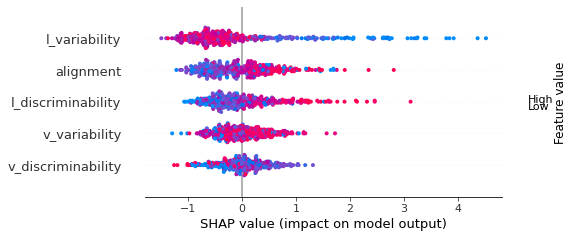

In [383]:
shap.summary_plot(shap_values, x)

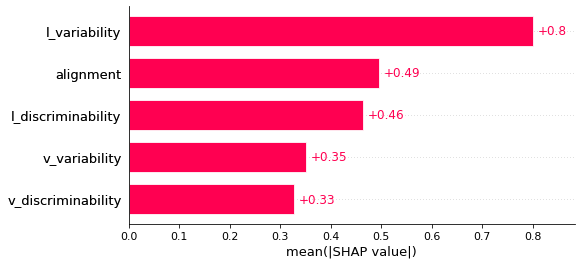

In [384]:
shap.plots.bar(shap_values)

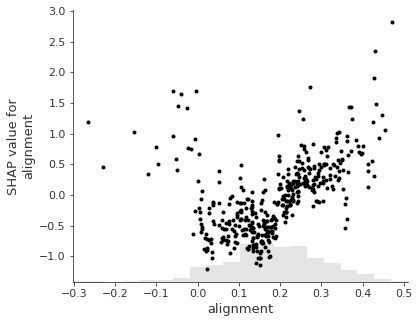

In [385]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:,"alignment"], color="black")

### Linear Regression

In [386]:
results = smf.ols(formula = 'aoa ~ alignment+v_variability+l_variability+v_discriminability+l_discriminability',data=df).fit()

In [387]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    aoa   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     23.41
Date:                Thu, 12 May 2022   Prob (F-statistic):           1.08e-20
Time:                        11:40:28   Log-Likelihood:                -862.94
No. Observations:                 414   AIC:                             1738.
Df Residuals:                     408   BIC:                             1762.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              3.5186      1.841      1.911      0.057      -0.100       7.137
alignment              1.8039      0.878      2.055      0.040       0.079       3.529
v_variability          3.4395      0.996      3.454      0.001       1.482       5.397
l_variability        -22.8041      2.860     -7.974      0.000     -28.426     -17.182
v_discriminability    -0.9354      1.366     -0.685      0.494      -3.621       1.750
l_discriminability     0.6525      0.126      5.175      0.000       0.405       0.900
==============================================================================
Omnibus:                       39.995   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.410
Skew:                           0.753   Prob(JB):                     1.13e-11
Kurtosis:                       3.809   Cond. No.                         271.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## nouns and verbs respectively

In [388]:
noun_visual_variability,noun_language_variability=get_variance(vg_noun_data)
verb_visual_variability,verb_language_variability=get_variance(vg_verb_data)

In [389]:
noun_visual_discriminability,noun_language_discriminability=get_distinctness_from_nearest_5(vg_noun_data)
verb_visual_discriminability,verb_language_discriminability=get_distinctness_from_nearest_5(vg_verb_data)

In [390]:
aoas,alignments,v_vars,l_vars,v_dists,l_dists=combine_all_data(aggregated_vg_noun_data,noun_aoa_dict,
                                                              noun_visual_variability,noun_language_variability,
                                                              noun_visual_discriminability,noun_language_discriminability)

In [391]:
df1=pd.DataFrame(data=np.transpose(np.array([aoas,alignments,v_vars,l_vars,v_dists,l_dists])),columns=['aoa','alignment','v_variability','l_variability','v_discriminability','l_discriminability'])
# df1['type']='noun'

In [392]:
# df1

In [393]:
aoas,alignments,v_vars,l_vars,v_dists,l_dists=combine_all_data(aggregated_vg_verb_data,verb_aoa_dict,
                                                              verb_visual_variability,verb_language_variability,
                                                              verb_visual_discriminability,verb_language_discriminability)

In [394]:
df2=pd.DataFrame(data=np.transpose(np.array([aoas,alignments,v_vars,l_vars,v_dists,l_dists])),columns=['aoa','alignment','v_variability','l_variability','v_discriminability','l_discriminability'])
# df2['type']='verb'

In [395]:
# df2

In [396]:
df=pd.concat([df1,df2])

In [397]:
# df

In [398]:
# df['type']=df['type'].astype("category")

In [399]:
# df.dtypes

### Xgboost

In [400]:
x=df.iloc[:,1:]

In [401]:
y=df.iloc[:,:1]

In [402]:
# # Shuffling the data
# X_shuffle, y_shuffle = shuffle(x, y)

In [403]:
# xgb_rg = xgb.XGBRegressor(max_depth=3, n_estimators=100,
#                             objective ='reg:linear', booster='gbtree',
#                             n_jobs=2)

# # Cross-validation with 10 folds
# mse = cross_val_score(xgb_rg, X_shuffle, y_shuffle,
#                          scoring='neg_mean_squared_error',
#                          cv=10, n_jobs=-1)

# print("MSE Values: ", -1 * np.round(mse, 2))
# print("Average MSE: ", -1 * np.mean(mse))

In [404]:
test_size=0.2
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size)

In [405]:
# xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
#                 max_depth = 5, alpha = 10, n_estimators = 10, tree_method="hist", enable_categorical=True)
xg_reg = xgb.XGBRegressor(max_depth=5,subsample=0.5,n_estimators=10000,learning_rate=0.002)

In [406]:
model=xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

In [407]:
r=pearsonr(np.array(y_test).squeeze(),np.array(preds))[0]
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("Pearson correlation: %f" % (r))
print("RMSE: %f" % (rmse))

Pearson correlation: 0.378233
RMSE: 2.140344


In [408]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(x)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [409]:
# # visualize the first prediction's explanation
# shap.plots.waterfall(shap_values[0])

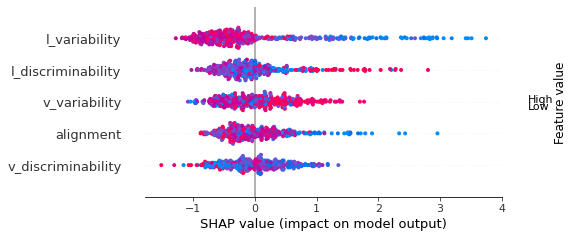

In [410]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

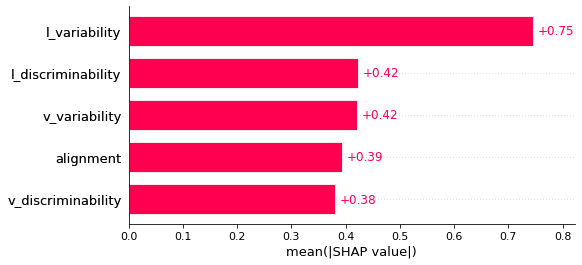

In [411]:
shap.plots.bar(shap_values)

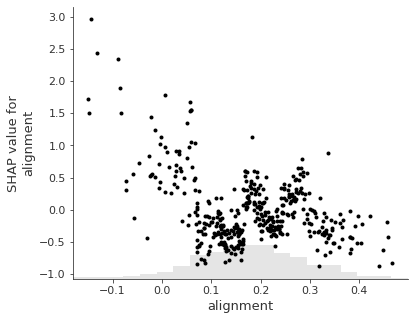

In [412]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:,"alignment"], color="black")

### Linear Regression

In [413]:
results = smf.ols(formula = 'aoa ~ alignment+v_variability+l_variability+v_discriminability+l_discriminability',data=df).fit()

In [414]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    aoa   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     19.94
Date:                Thu, 12 May 2022   Prob (F-statistic):           8.40e-18
Time:                        11:40:40   Log-Likelihood:                -869.88
No. Observations:                 414   AIC:                             1752.
Df Residuals:                     408   BIC:                             1776.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              6.7409      1.984      3.398      0.001       2.842      10.640
alignment             -1.9592      0.911     -2.151      0.032      -3.750      -0.169
v_variability          3.1983      1.074      2.977      0.003       1.086       5.310
l_variability        -23.7078      2.890     -8.202      0.000     -29.390     -18.026
v_discriminability    -0.7896      1.199     -0.659      0.511      -3.147       1.568
l_discriminability     0.3866      0.134      2.874      0.004       0.122       0.651
==============================================================================
Omnibus:                       34.896   Durbin-Watson:                   1.797
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.880
Skew:                           0.710   Prob(JB):                     8.05e-10
Kurtosis:                       3.642   Cond. No.                         272.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""